# **Analyse PCAPS**

Notebook to analyse MIoT pcap files.

## i. Imports

In [1]:
import os
import sys
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scapy.all import *

## **1. Setup**

In [2]:
# Directories
BASEDIR = os.getcwd()
DATADIR = os.path.join(BASEDIR, 'data')
PCAPDIR = os.path.join(DATADIR, 'pcaps')
FIGUREDIR = os.path.join(BASEDIR, 'figures')

# Devices
devices = ['ihealth_bpm', 'viatom_wpo', 'vivachek_bgm']

# Coluor palette
sns.set_palette('deep')

In [3]:
# Custom functions
def bold(string):
    """
    Make string bold.

    Args:
        string (str): String to be made bold.

    Returns:
        string: Bold string.

    Raises:
        TypeError: If the input is not a string.
    """
    # Check input type
    if not isinstance(string, str):
        raise TypeError("Input must be a string!")
    
    return "\033[1m" + string + "\033[0m"

## **2. Load data**

### 2.1 Read pcap files

In [4]:
# Data dictionary
data_dict = {}

# Loop over devices
for device in devices:
    # Filtered dataset
    print(f'Loading packets for {device}...')
    data_dict[device] = {}
    filtered_data_dir = os.path.join(PCAPDIR, device, 'filtered')

    # Loop over experiments
    for i in ['1', '2', '3', '4', '5']:
        # Check file exists
        filtered_data_file = os.path.join(filtered_data_dir, f'{device}_filtered_{i}.pcapng')
        if not os.path.exists(filtered_data_file):
            print(f'No file exists for {device} number {i}!')
            continue
        
        # Load packets and put into dictionary
        packets = rdpcap(filtered_data_file)
        data_dict[device][i] = packets

Loading packets for ihealth_bpm...
Loading packets for viatom_wpo...
Loading packets for vivachek_bgm...


### 2.2 Load packet features

In [8]:
# Data containers
packet_length_dict = {}
packet_type_dict = {}
packet_times = {}
inter_packet_times = {}

# Loop over device and experiment
for device in data_dict:
    packet_length_dict[device] = {}
    packet_type_dict[device] = {}
    packet_times[device] = {}
    inter_packet_times[device] = {}
    for i in data_dict[device]:
        packet_length_dict[device][i] = {}
        packet_type_dict[device][i] = {}
        packet_times[device][i] = []
        inter_packet_times[device][i] = []

        # Loop over packets
        for packet in data_dict[device][i]:
            packet_times[device][i].append(float(packet.time))
            packet_len = len(packet)
            try:
                packet_length_dict[device][i][packet_len] += 1
            except KeyError:
                packet_length_dict[device][i][packet_len] = 1
            RF_layer = packet
            BLE_layer = packet.payload
            ADV_layer = BLE_layer.payload
            ADV_event_layer = ADV_layer.payload
            ADV_event_name = ADV_event_layer.name
            try:
                packet_type_dict[device][i][ADV_event_name] += 1
            except KeyError:
                packet_type_dict[device][i][ADV_event_name] = 1

            # Add to total
            try:
                packet_type_dict[device][i]['Total'] += 1
                packet_length_dict[device][i]['Total'] += 1
            except KeyError:
                packet_type_dict[device][i]['Total'] = 1
                packet_length_dict[device][i]['Total'] = 1

        # Sort timings
        packet_times[device][i] = sorted(packet_times[device][i])
        tmp_list = []
        for ind, x in enumerate(packet_times[device][i]):
            if ind != 0:
                time_diff = np.round(x - packet_times[device][i][ind-1], 6)
                tmp_list.append(tmp_list[ind-1] + time_diff)
                inter_packet_times[device][i].append(time_diff)
            else:
                tmp_list.append(0)
        packet_times[device][i] = tmp_list

## **3. Analyse packets within device**

### 3.1 Packet lengths and types

#### 3.1.1 Determine proportions

In [9]:
# Data containers
packet_length_proportion_dict = {}
packet_type_proportion_dict = {}

# Loop over device and experiment
for device in data_dict:
    packet_length_proportion_dict[device] = {}
    packet_type_proportion_dict[device] = {}
    for i in data_dict[device]:
        packet_length_proportion_dict[device][i] = {}
        packet_type_proportion_dict[device][i] = {}

        # Lengths
        for n in packet_length_dict[device][i]:
            if n == 'Total':
                continue
            prop = packet_length_dict[device][i][n] / packet_length_dict[device][i]['Total']
            packet_length_proportion_dict[device][i][n] = prop

        # Types
        for n in packet_type_dict[device][i]:
            if n == 'Total':
                continue
            prop = packet_type_dict[device][i][n] / packet_type_dict[device][i]['Total']
            packet_type_proportion_dict[device][i][n] = prop


#### 3.1.2 Plot proportions

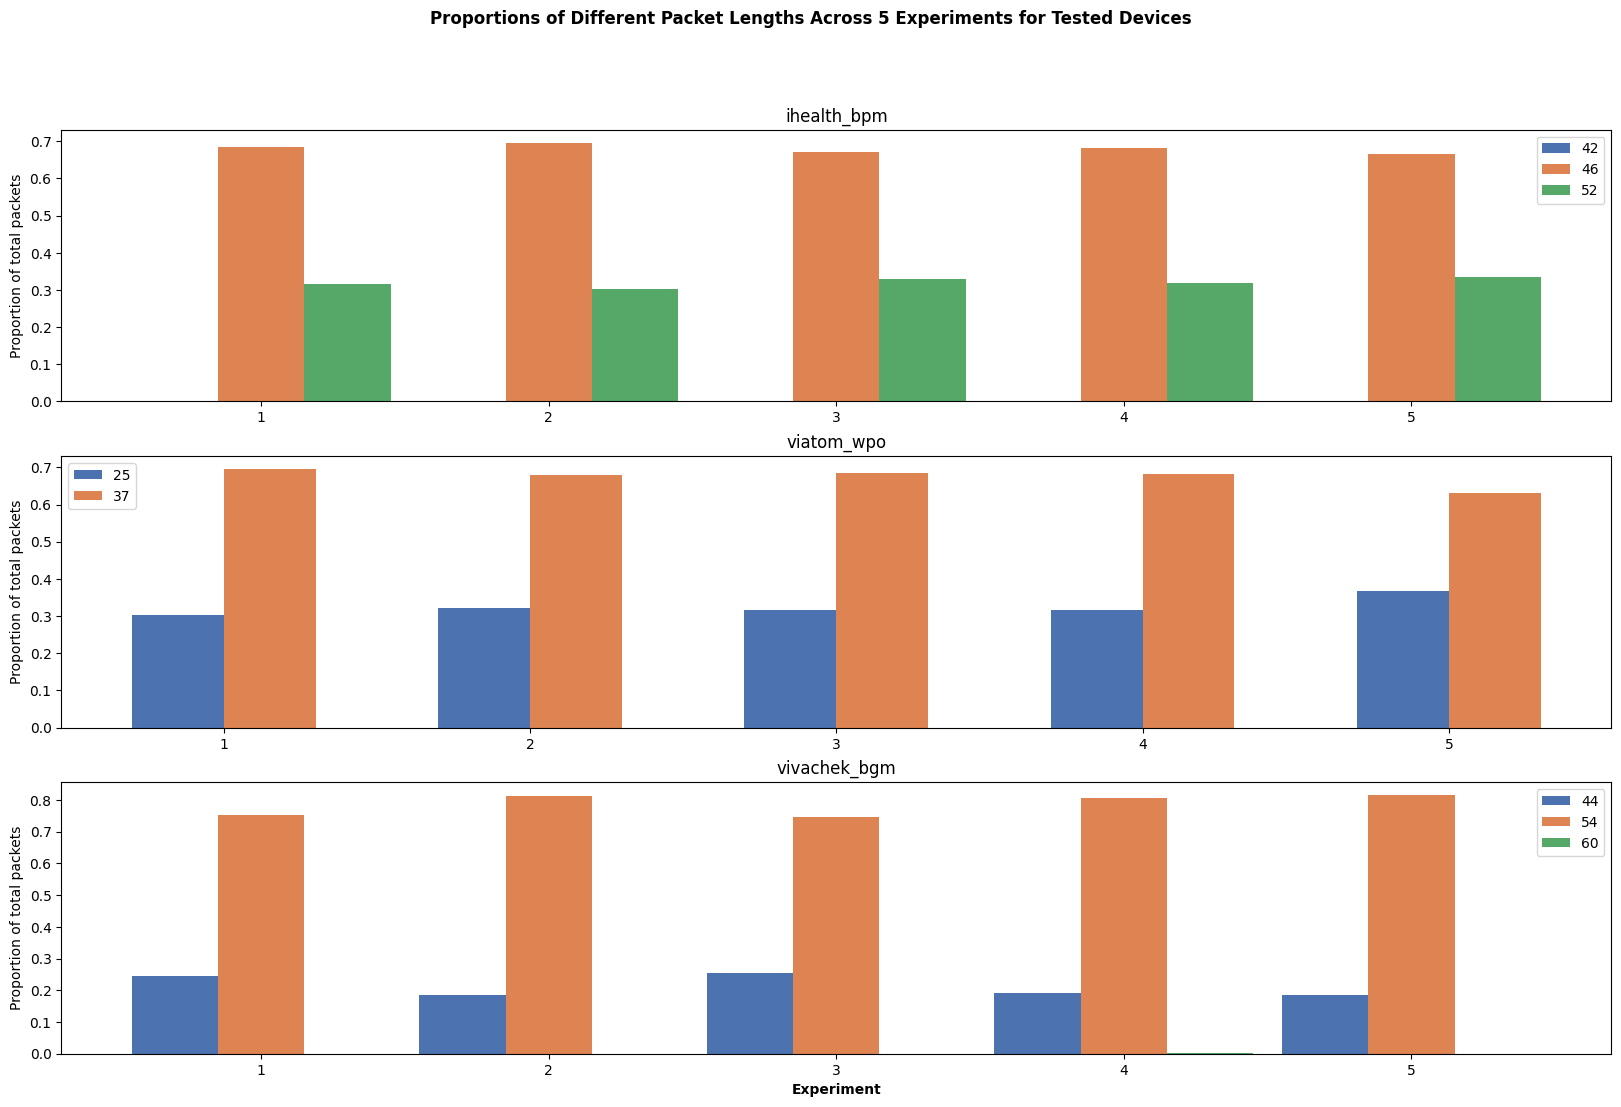

In [10]:
# Make subplots
fig, ax = plt.subplots(3,1, figsize=(20,12))

# Loop over devices and create labels
for ax_i, device in enumerate(packet_length_proportion_dict):
    labels = list(packet_length_proportion_dict[device].keys())

    # Determine unique values
    unique = {}
    for i in labels:
        for val in packet_length_proportion_dict[device][i].keys():
            if val not in unique:
                unique[val] = []
    
    # Create list of value proportions
    for _len in unique:
        for i in labels:
            try:
                unique[_len].append(packet_length_proportion_dict[device][i][_len])
            except KeyError:
                unique[_len].append(0)

    # Bar chart formatting
    x = np.arange(len(labels)) + 1  # the label locations
    width = 0.3  # the width of the bars

    # Plot bar chart
    legend = sorted(list(unique.keys()))
    if len(legend) == 2:
        pos = x - width/2
    else:
        pos = x - width
    for val in legend:
        bar = ax[ax_i].bar(pos, unique[val], width, label=str(val))
        pos = pos + width
    ax[ax_i].set_title(device)
    ax[ax_i].set_ylabel('Proportion of total packets')
    ax[ax_i].legend()

# PLot figure
plt.ylabel('Proportion of total packets')
plt.xlabel('Experiment', fontweight='bold')
plt.suptitle('Proportions of Different Packet Lengths Across 5 Experiments for Tested Devices', fontweight='bold')
plt.savefig(os.path.join(FIGUREDIR, f'packet_lengths.png'))
plt.show()

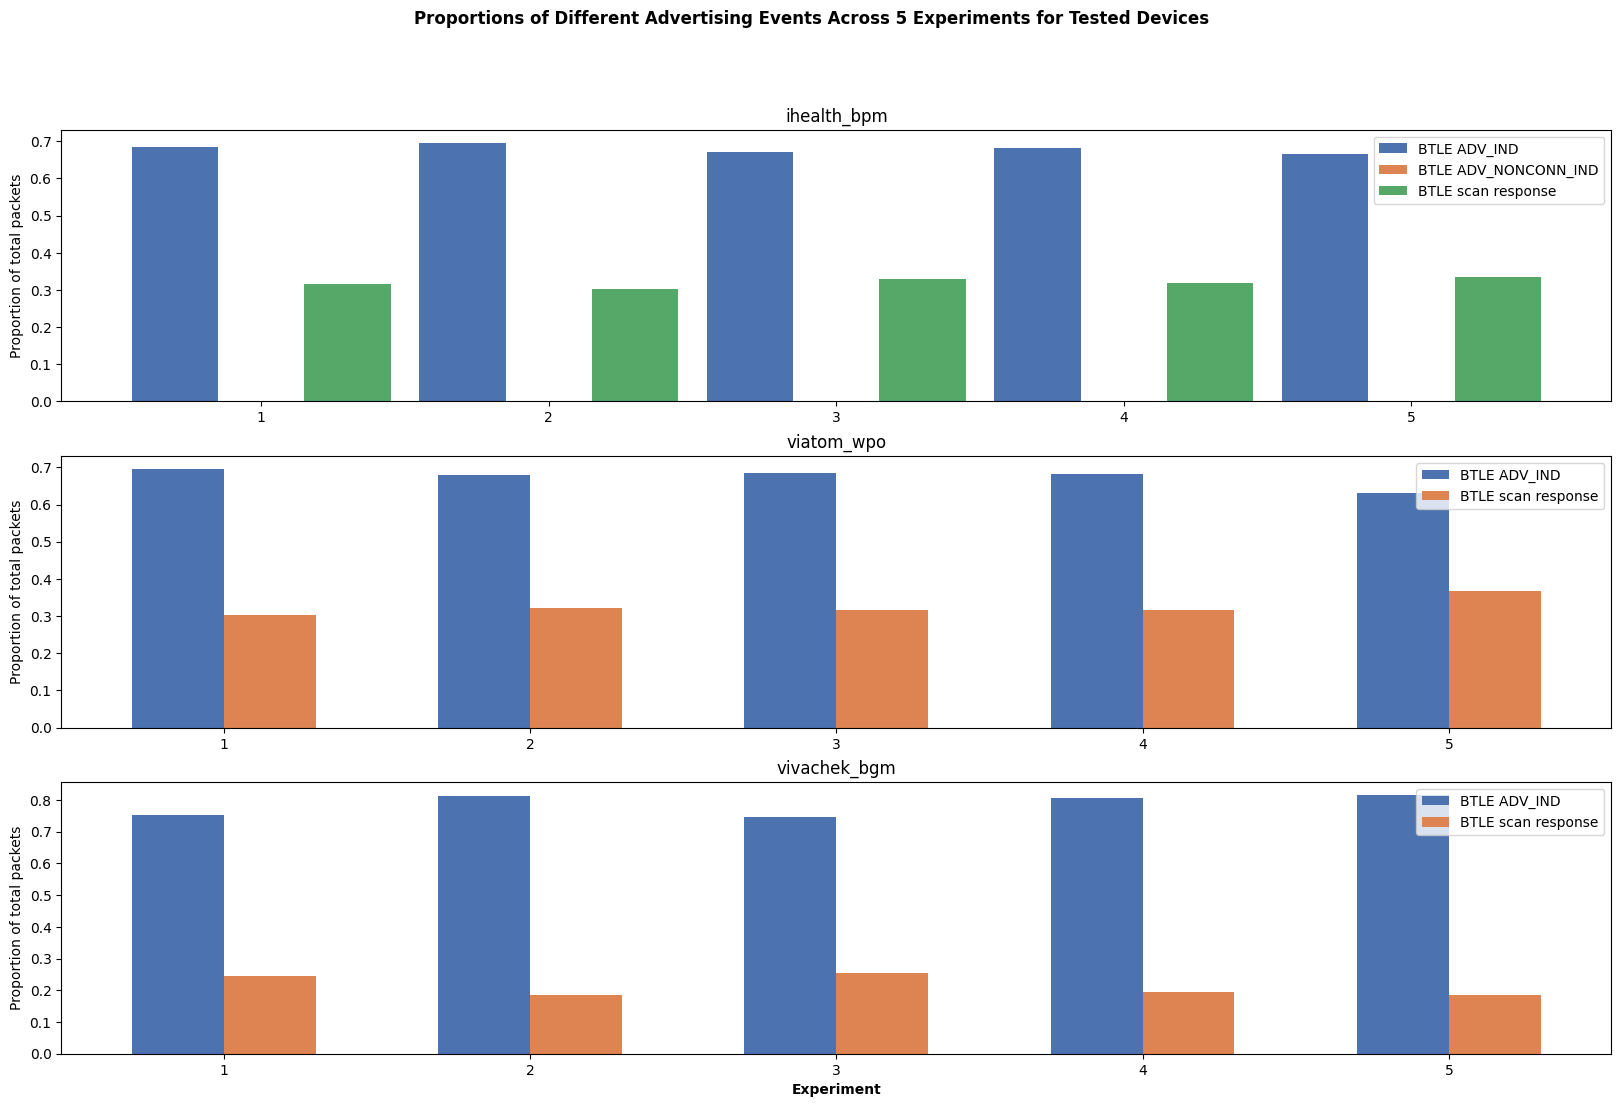

In [11]:
# Make subplots
fig, ax = plt.subplots(3,1, figsize=(20,12))

# Loop over devices and create labels
for ax_i, device in enumerate(packet_type_proportion_dict):
    labels = list(packet_type_proportion_dict[device].keys())

    # Determine unique values
    unique = {}
    for i in labels:
        for val in packet_type_proportion_dict[device][i].keys():
            if val not in unique:
                unique[val] = []
    
    # Create list of value proportions
    for _len in unique:
        for i in labels:
            try:
                unique[_len].append(packet_type_proportion_dict[device][i][_len])
            except KeyError:
                unique[_len].append(0)

    # Bar chart formatting
    x = np.arange(len(labels)) + 1  # the label locations
    width = 0.3  # the width of the bars

    # Plot bar chart
    legend = sorted(list(unique.keys()))
    if len(legend) == 2:
        pos = x - width/2
    else:
        pos = x - width
    for val in legend:
        bar = ax[ax_i].bar(pos, unique[val], width, label=str(val))
        pos = pos + width
    ax[ax_i].set_title(device)
    ax[ax_i].set_ylabel('Proportion of total packets')
    ax[ax_i].legend()

# PLot figure
plt.ylabel('Proportion of total packets')
plt.xlabel('Experiment', fontweight='bold')
plt.suptitle('Proportions of Different Advertising Events Across 5 Experiments for Tested Devices', fontweight='bold')
plt.savefig(os.path.join(FIGUREDIR, f'packet_types.png'))
plt.show()

#### 3.1.3 Average proportions

In [12]:
# Adverising events
events = ['BTLE ADV_IND', 'BTLE scan response']

# Loop over devices and create labels
for device in packet_type_proportion_dict:
    print('')
    print(bold(device))
    for type in events:
        count = 0
        total = 0
        for i in packet_type_proportion_dict[device]:
            total += packet_type_proportion_dict[device][i][type]
            count += 1
        av = total/count
        print(type, f'{av:.2f}')


ihealth_bpm
BTLE ADV_IND 0.68
BTLE scan response 0.32

viatom_wpo
BTLE ADV_IND 0.67
BTLE scan response 0.33

vivachek_bgm
BTLE ADV_IND 0.79
BTLE scan response 0.21


### 3.2 Packet times

#### 3.2.1 Inter packet timings

In [16]:
# Loop over device and experiment
total_data = []
total_labels = []
for device in data_dict:
    for i in data_dict[device]:
        # Create total data and label lists
        total_data += inter_packet_times[device][i][:]
        total_labels += [device for x in inter_packet_times[device][i][:]]

# Save values and labels to dataset file
inter_packet_csv  = os.path.join(DATADIR, 'inter_packet_timings.csv')
with open(inter_packet_csv, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(['Interpacket Timing'] + total_data,
                         ['Device'] + total_labels))

#### 3.2.1 Inter packet frequency

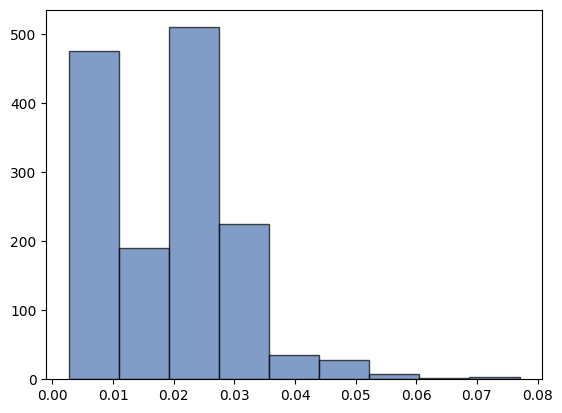

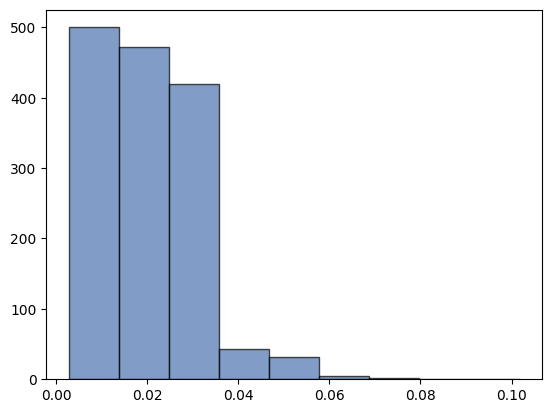

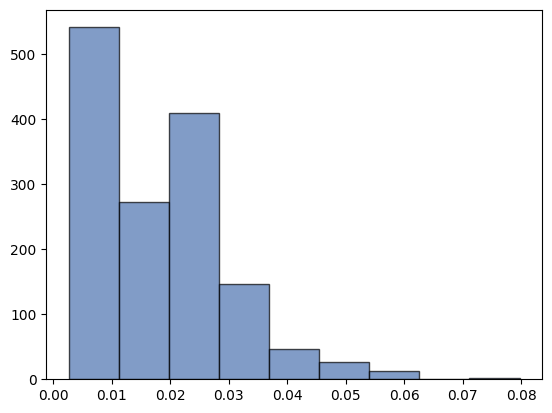

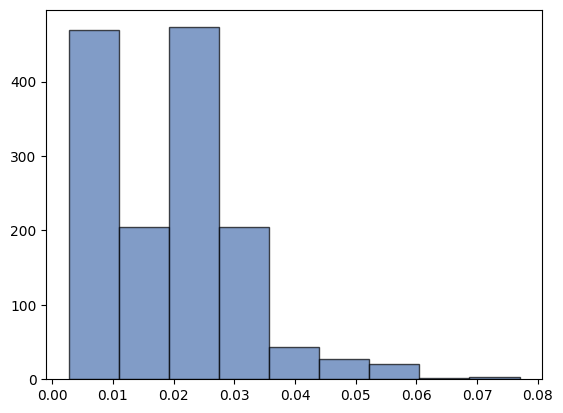

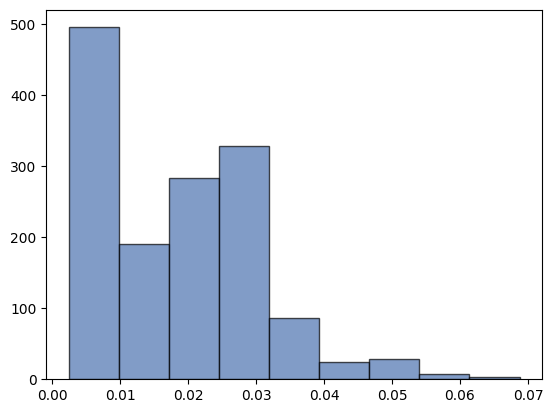

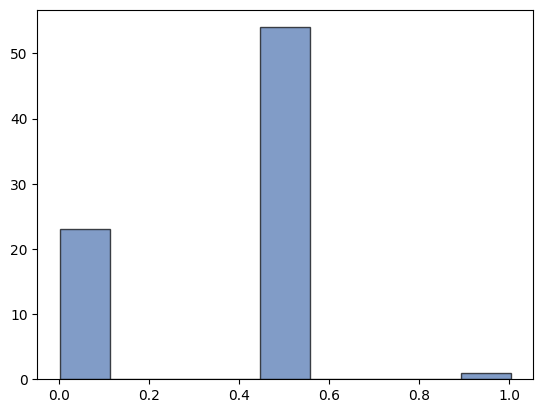

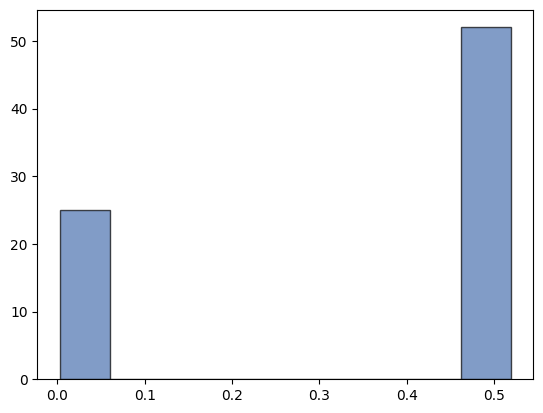

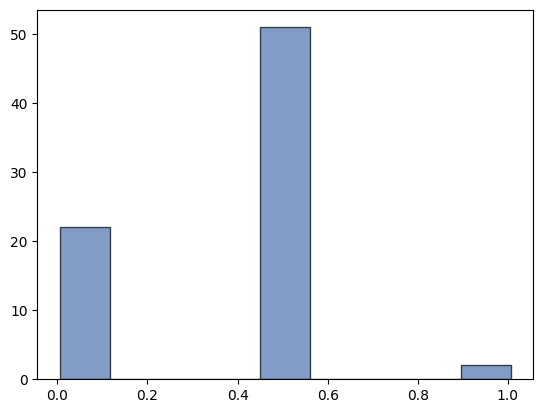

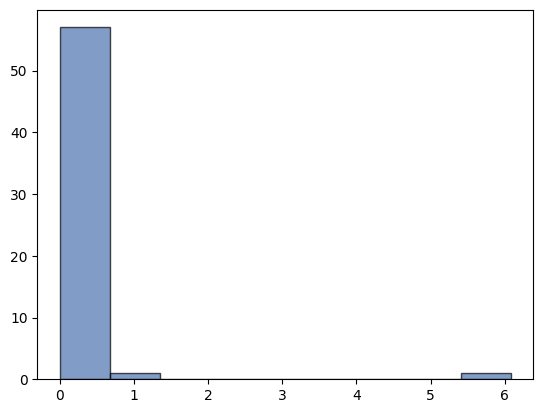

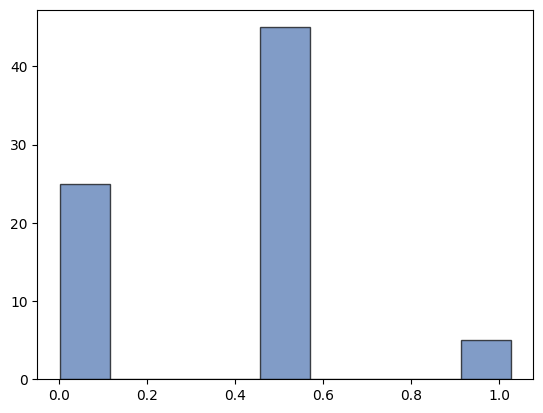

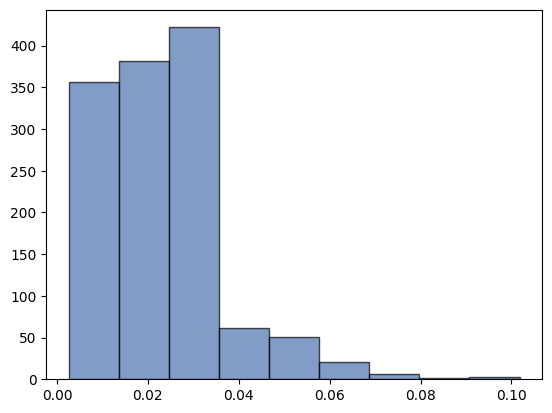

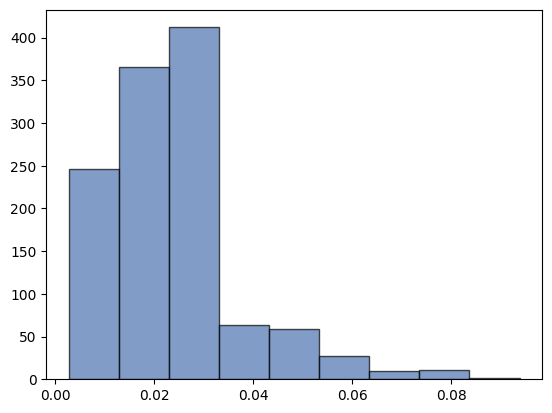

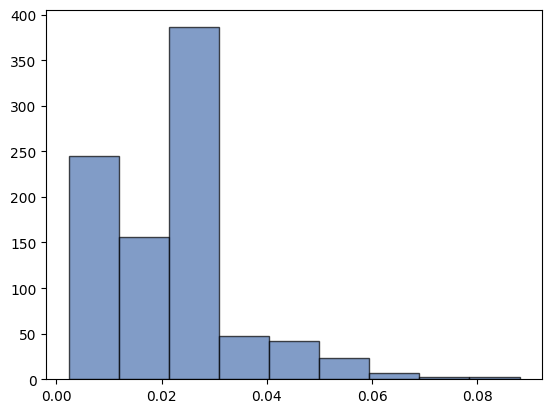

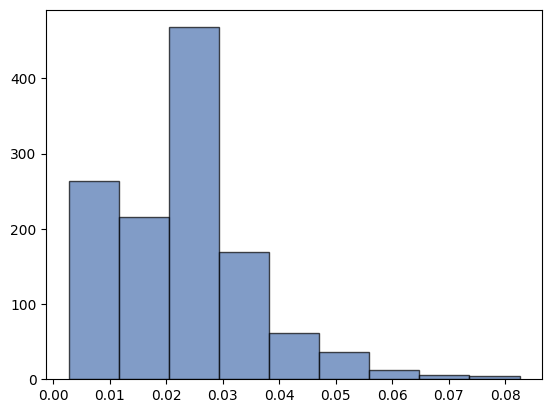

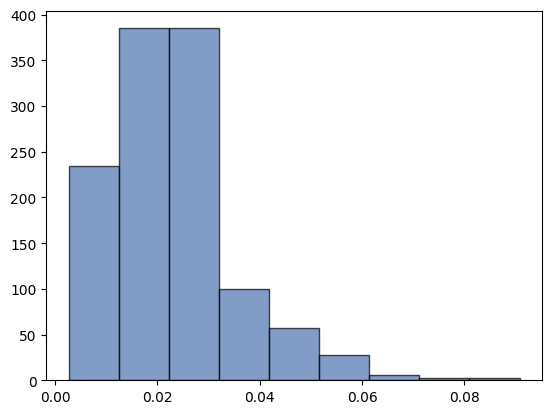

In [14]:
# Loop over device and experiment
for device in data_dict:
    for i in data_dict[device]:
        times_list = inter_packet_times[device][i]
        bins = np.linspace(np.min(times_list), np.max(times_list), 10)
        plt.hist(times_list, bins=bins, edgecolor='k', alpha=0.7)
        plt.show()